<a href="https://colab.research.google.com/github/jackysiupuichung/machine-learning-for-drug-discovery/blob/main/machine_learning_for_drug_discovery_identify_gene_target_for_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.5 MB/s 


In [3]:
pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

Dataset description: 

part of the RNA-Seq (HiSeq) PANCAN data set, it is a random extraction of gene expressions of patients having different types of tumor: BRCA, KIRC, COAD, LUAD and PRAD.

Weinstein, John N., et al. 'The cancer genome atlas pan-cancer analysis project.' Nature genetics 45.10 (2013): 1113-1120.




In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz

--2022-11-21 12:54:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72856320 (69M) [application/x-httpd-php]
Saving to: ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’

TCGA-PANCAN-HiSeq-8 100%[===================>]  69.48M  19.5MB/s    in 4.1s    

2022-11-21 12:54:06 (17.0 MB/s) - ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz’ saved [72856320/72856320]



In [6]:
!tar -xf TCGA-PANCAN-HiSeq-801x20531.tar.gz

In [138]:
labels = pd.read_csv("/content/TCGA-PANCAN-HiSeq-801x20531/labels.csv")
data = pd.read_csv("/content/TCGA-PANCAN-HiSeq-801x20531/data.csv")

In [93]:
print(labels.shape, data.shape)

(801, 2) (801, 20531)


In [141]:
data.iloc[: , 0] = labels.iloc[: , 1]

In [139]:
data.iloc[: , 1:] = data.iloc[: , 1:].astype(float, 64)

In [147]:
data = data.rename(columns = {'Unnamed: 0':'type'})

Data augmentation and cleaning

distribution of the 5 cancer types:imbalance of cancer samples

In [148]:
data['type'].value_counts()
#TODO: scikit-learn class weight adjustment

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: type, dtype: int64

In [149]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data["type"] = ord_enc.fit_transform(data[["type"]])
data["type"]

0      4.0
1      3.0
2      4.0
3      4.0
4      0.0
      ... 
796    0.0
797    3.0
798    1.0
799    4.0
800    4.0
Name: type, Length: 801, dtype: float64

In [151]:
X=data.drop(columns='type')
y=data['type']

check for empty entries within gene expression data

In [14]:
#no empty entries were found
np.where(pd.isnull(data))

(array([], dtype=int64), array([], dtype=int64))

Normalization

In [152]:
from sklearn.preprocessing import StandardScaler
# get the features and label from the original dataframe
# performing standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

PCA analysis

Cumulative Variances (Percentage):
[10.53978135 19.29401382 27.10409487 32.26974187 36.29867353 39.21955484
 41.57429003 43.71958912 45.35159047 46.58548996 47.6395855  48.53413707
 49.38456972 50.13755362 50.80416425 51.45110385 52.05971839 52.64477902
 53.17414492 53.68963449 54.17889313 54.64472679 55.099725   55.54736107
 55.97222959 56.39036797 56.79279452 57.18640152 57.57680228 57.93548971
 58.29307258 58.64305069 58.98038922 59.31291204 59.63758218 59.9577075
 60.26692852 60.56212273 60.84714913 61.12754717 61.4046845  61.67362939
 61.93967142 62.20071284 62.45957521 62.7151432  62.96738351 63.21655331
 63.46036769 63.69822788 63.93200683 64.16169123 64.38847045 64.61337962
 64.83084641 65.04580358 65.25887722 65.46963791 65.67444277 65.87868376
 66.07854109 66.27617166 66.47349454 66.66835989 66.86085286 67.04513489
 67.22728882 67.40669627 67.58352289 67.7597773  67.93229119 68.10301183
 68.27245383 68.44063069 68.60543036 68.7684436  68.92850088 69.08593882
 69.2418241  69.3

Text(0, 0.5, 'Explained variance (%)')

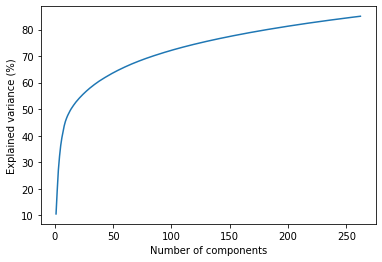

In [155]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.85)
pca.fit(X_scaled)
print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')
# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [157]:
pca_components = abs(pca.components_)
print(pca_components)

[[0.00097941 0.00235639 0.00496579 ... 0.00233708 0.00195967 0.00104891]
 [0.00230787 0.00637287 0.00046648 ... 0.01493974 0.00232062 0.00100493]
 [0.00025614 0.00145302 0.00602132 ... 0.00300221 0.00704655 0.00215189]
 ...
 [0.00520681 0.00627539 0.00182062 ... 0.00450521 0.01516751 0.00047649]
 [0.00953311 0.00844804 0.00332909 ... 0.0042475  0.00802586 0.01081098]
 [0.00330387 0.01810062 0.01424377 ... 0.00614902 0.00922012 0.00071795]]


In [159]:
print('Top 4 most important features in each component')
print('===============================================')
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {data.columns[indices].to_list()}')

Top 4 most important features in each component
Component 0: ['gene_19861', 'gene_17359', 'gene_13488', 'gene_15157']
Component 1: ['gene_3611', 'gene_1221', 'gene_14698', 'gene_1009']
Component 2: ['gene_1136', 'gene_11909', 'gene_3736', 'gene_9074']
Component 3: ['gene_11671', 'gene_28', 'gene_8348', 'gene_19599']
Component 4: ['gene_7294', 'gene_19278', 'gene_1544', 'gene_11902']
Component 5: ['gene_9506', 'gene_7190', 'gene_19561', 'gene_6527']
Component 6: ['gene_2780', 'gene_10259', 'gene_15154', 'gene_13156']
Component 7: ['gene_239', 'gene_7746', 'gene_4064', 'gene_13009']
Component 8: ['gene_725', 'gene_15322', 'gene_11491', 'gene_3179']
Component 9: ['gene_4483', 'gene_4470', 'gene_16047', 'gene_8224']
Component 10: ['gene_15405', 'gene_3481', 'gene_11897', 'gene_14390']
Component 11: ['gene_18263', 'gene_8875', 'gene_12019', 'gene_11194']
Component 12: ['gene_18540', 'gene_8651', 'gene_630', 'gene_327']
Component 13: ['gene_1242', 'gene_11814', 'gene_2678', 'gene_1568']
Comp

In [164]:
X_pca = pca.transform(X_scaled)
print(X_pca.shape)
print(X_pca)

(801, 262)
[[-57.44698695  95.41098073  74.30154327 ...  -4.3385352    4.91229497
   10.63697698]
 [-16.91943005   0.73247033 -64.07289959 ...   3.00122895   0.38203271
    1.61960023]
 [-70.34521789 -19.3033266   20.48824046 ...  -1.02767216  -0.52979929
   -7.86963844]
 ...
 [ -4.13308968  15.69001387 -22.64445347 ...   0.86730495  -0.77385759
   -0.75955759]
 [-30.81475746  33.52642255  70.56563586 ...   6.76222818  -1.83980826
    2.97090657]
 [-22.34455668   4.05235632  32.3278757  ...  -1.69407171   0.27711929
   -2.86377254]]


In [185]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [188]:
data['pca-one'] = X_pca[:,0]
data['pca-two'] = X_pca[:,1] 
data['pca-three'] = X_pca[:,2]

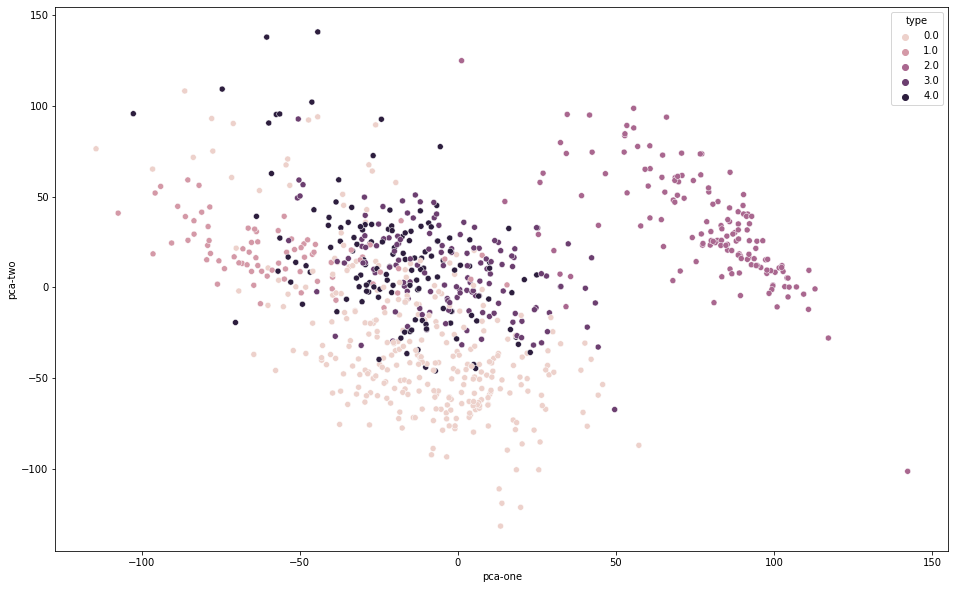

In [190]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=data['pca-one'], y=data['pca-two'],
    hue=data['type'],
    data=X_pca,
    legend="full",
)

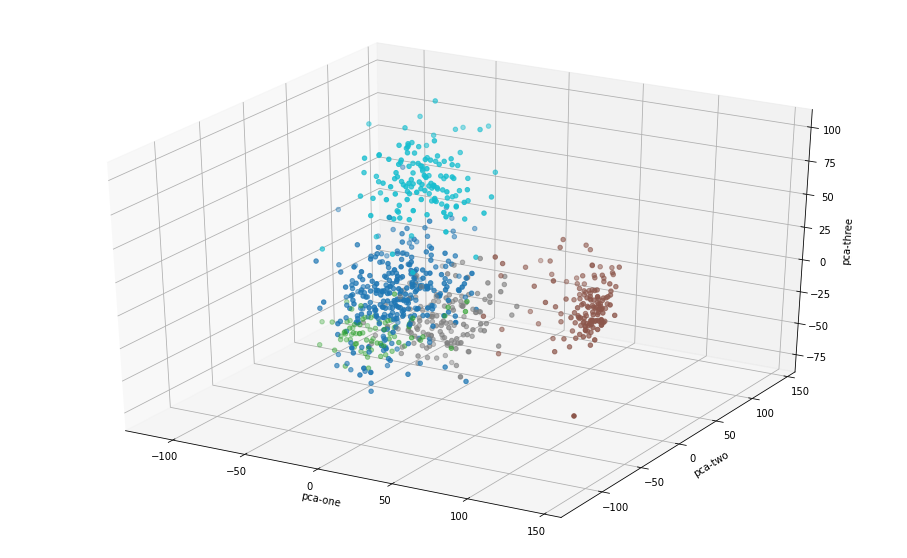

In [192]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    zs=data['pca-three'] ,
    xs=data['pca-one'], 
    ys=data['pca-two'] ,
    c=data['type'], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [160]:
col=["type"]
from sklearn.preprocessing import OneHotEncoder
df_new=pd.get_dummies(data,columns=col)
df_new

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,type_0.0,type_1.0,type_2.0,type_3.0,type_4.0
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,12.003135,9.650743,8.921326,5.286759,0.000000,0,0,0,0,1
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,12.674552,10.517059,9.397854,2.094168,0.000000,0,0,0,1,0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,9.045255,9.788359,10.090470,1.683023,0.000000,0,0,0,0,1
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,11.392682,9.694814,9.684365,3.292001,0.000000,0,0,0,0,1
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,11.922439,9.217749,9.461191,5.110372,0.000000,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,12.031267,9.813063,10.092770,8.819269,0.000000,1,0,0,0,0
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,11.633422,10.317266,8.745983,9.659081,0.000000,0,0,0,1,0
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,12.180944,10.681194,9.466711,4.677458,0.586693,0,1,0,0,0
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,11.198279,10.335513,10.400581,5.718751,0.000000,0,0,0,0,1


In [162]:
y_new= df_new[['type_0.0','type_1.0','type_2.0','type_3.0','type_4.0']]

make train_test_split from pca gene expression data and one hot encoded cancer type

!!!ideally implement multi-labelled stratification (http://scikit.ml/stratification.html) to avoid dataset imbalance.  

In [180]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest=train_test_split(X_pca, y_new, train_size=0.7, random_state=123)
print(len(xtest))

241


In [181]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline 

classifier = MultiOutputClassifier(XGBClassifier())
clf = Pipeline([('classify', classifier)
               ])
print (clf)


clf.fit(xtrain, ytrain)
print(clf.score(xtrain, ytrain))

yhat = clf.predict(xtest)



Pipeline(steps=[('classify', MultiOutputClassifier(estimator=XGBClassifier()))])
1.0


In [182]:
auc_y1 = roc_auc_score(ytest,yhat)
auc_y1

0.9687678721614802

In [183]:
cr_y1 = classification_report(ytest,yhat,)

print (cr_y1)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        84
           1       1.00      0.86      0.93        29
           2       1.00      1.00      1.00        52
           3       1.00      0.89      0.94        35
           4       1.00      0.98      0.99        41

   micro avg       1.00      0.95      0.97       241
   macro avg       1.00      0.94      0.97       241
weighted avg       1.00      0.95      0.97       241
 samples avg       0.95      0.95      0.95       241



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
